In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [3]:
import decoding_analysis_vis as dav
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import xarray as xr
sns.set_palette('colorblind')

In [4]:
AllSesDict = {xx: dav.AllSessions(memory_efficient=True, sess_type=xx) for xx in ['sens', 'proj']}

session name : 2020-09-04_RL093.pkl


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally
Excluded 302 out of 2097 neurons
session name : 2020-09-08_RL099.pkl
Excluded 276 out of 2095 neurons
session name : 2020-09-14_RL101.pkl
Excluded 602 out of 2169 neurons
session name : 2020-09-16_RL103.pkl
Excluded 461 out of 2106 neurons
session name : 2020-10-02_RL108.pkl
Excluded 969 out of 2563 neurons
session name : 2020-10-12_RL109.pkl
Excluded 843 out of 2515 neurons
Individual sessions loaded
session name : 2021-02-18_RL127.pkl
Excluded 833 out of 2334 neurons
session name : 2021-02-22_RL128.pkl
Excluded 893 out of 2308 neurons
session name : 2021-02-23_RL129.pkl
Excluded 1323 out of 2364 neurons
session name : 2021-02-24_RL132.pkl
Excluded 757 out of 2156 neurons
session name : 2021-02-25_RL131.pkl
Excluded 1361 out of 2448 neurons
session name : 2021-03-02_RL130.pkl
Excluded 518 out of 2258 neurons
Individual sessions loaded


In [11]:
tmp = dav.SimpleSession(verbose=1, session_id=0, sess_type='proj',
                        shuffle_trial_labels=False,
                        shuffle_timepoints=False,
                        shuffle_all_data=False,
                        prestim_baseline=False,
                        bool_filter_neurons=True)

# tmp = None                        

session name : 2021-02-18_RL127.pkl
Excluded 833 out of 2334 neurons


In [29]:
# tmpr = tmp.dataset_selector(region='s1', min_t=-0.9, max_t=1.9, trial_type_list=['sensory', 'random'], 
#                             deepcopy=True)  
tmpr = tmp.dataset_selector(region='s1', frame_id=78, trial_type_list=['sensory', 'random'], 
                            deepcopy=True)  


In [5]:
## Get p values for all data aggregated (in AllSesDict)
tt_list_dict = {'sens': ['sham', 'sensory', 'random', 'whisker'],
                'proj': ['sham', 'projecting', 'non_projecting']}

selected_data_dict = {}
p_val_super_dict = {}
for xx in ['sens', 'proj']:
    for reg in ['s1', 's2']:
        print(f'Now selecting {xx} in {reg}')
        selected_data_dict[f'{xx}_{reg}'] = AllSesDict[xx].dataset_selector(AllSesDict[xx], region=reg, min_t=-2, max_t=6, 
                                                                        trial_type_list=tt_list_dict[xx],
                                                                        exclude_targets_s1=True)
        _, p_val_super_dict[f'{xx}_{reg}'] = dav.compute_dynamic_pvals(ds=selected_data_dict[f'{xx}_{reg}'], 
                                                                        tt_list=tt_list_dict[xx],  
                                                                        first_frame=np.where(AllSesDict[xx].full_ds.artefact_bool)[0][-1] + 1)  # first post-stim dp
                                                                        # first_frame=selected_data_dict[f'{xx}_{reg}'].frame_array.data[0])  # first dp

Now selecting sens in s1
sham_sensory
sham_random
sham_whisker
sensory_random
sensory_whisker
random_whisker
Now selecting sens in s2
sham_sensory
sham_random
sham_whisker
sensory_random
sensory_whisker
random_whisker
Now selecting proj in s1
sham_projecting
sham_non_projecting
projecting_non_projecting
Now selecting proj in s2
sham_projecting
sham_non_projecting
projecting_non_projecting


In [11]:
len(AllSesDict['sens'].sess_dict)

6

In [10]:
if False:
    ## Get p values for all data aggregated (in AllSesDict)
    tt_list_dict = {'sens': ['sham', 'sensory', 'random'],
                    'proj': ['sham', 'projecting', 'non_projecting']}

    selected_data_dict = {}
    p_val_super_dict = {}
    n_ses = 6
    for xx in ['sens', 'proj']:
        for reg in ['s1', 's2']:
            print(f'Now selecting {xx} in {reg}')
            ## Create empty dicts for indiv sessions
            selected_data_dict[f'{xx}_{reg}'] = {}
            p_val_super_dict[f'{xx}_{reg}'] = {}
            assert len(AllSesDict[xx].sess_dict) == n_ses, 'number of sessions not as expected'

            for i_s in range(n_ses):
                curr_ses = AllSesDict[xx].sess_dict[i_s]

                selected_data_dict[f'{xx}_{reg}'][i_s] = curr_ses.dataset_selector(region=reg, #min_t=-2, max_t=6, 
                                                                                trial_type_list=tt_list_dict[xx],
                                                                                exclude_targets_s1=True)
                _, p_val_super_dict[f'{xx}_{reg}'][i_s] = dav.compute_dynamic_pvals(ds=selected_data_dict[f'{xx}_{reg}'][i_s], 
                                                                                tt_list=tt_list_dict[xx],  
                                                                                first_frame=np.where(curr_ses.full_ds.artefact_bool)[0][-1] + 1)  # first post-stim dp
                                                                                # first_frame=selected_data_dict[f'{xx}_{reg}'].frame_array.data[0])  # first dp

Now selecting sens in s1


AttributeError: 'NoneType' object has no attribute 'dataset_selector'

## Grand average using all data from all sessions

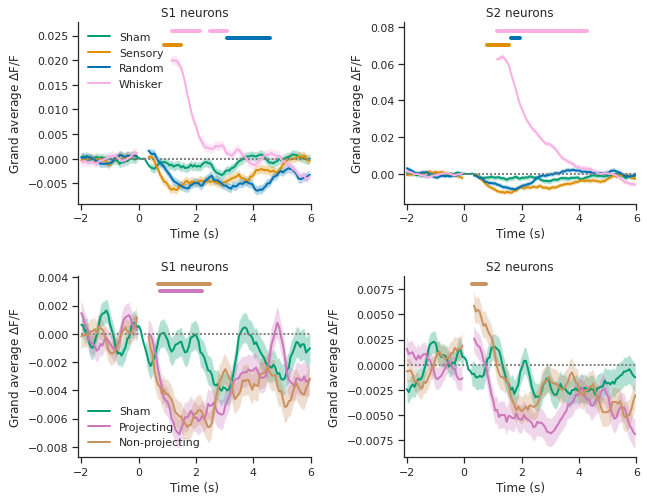

In [7]:
save_fig = True

fig, ax_av = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})

dict_height_sign = {'sens_s1': 0.023, 'sens_s2': 0.07, 'proj_s1': 0.003, 'proj_s2': 0.007}
dict_addition_sign = {'sens_s1': 0.0015, 'sens_s2': 0.004, 'proj_s1': 0.0005, 'proj_s2': 0.001}
for i_xx, xx in enumerate(['sens', 'proj']):
    for i_reg, reg in enumerate(['s1', 's2']):
        signficance_sham_only_dict = {k: v for k, v in p_val_super_dict[f'{xx}_{reg}'].items() if k[:4] == 'sham'}
        curr_ax = ax_av[i_xx, i_reg]
        dav.plot_grand_average(ds=selected_data_dict[f'{xx}_{reg}'], ax=curr_ax, smooth_mean=True,
                               tt_list=tt_list_dict[xx], plot_legend=(reg == 's1'),
                               plot_significance=True, test_method='cluster',
                               legend_profile=2 if xx == 'sens' else 0,
                                p_val_dict=signficance_sham_only_dict,
                                bottom_sign_bar=dict_height_sign[f'{xx}_{reg}'],
                                addition_sign_bar=dict_addition_sign[f'{xx}_{reg}'],
                               first_frame_significance=np.where(AllSesDict[xx].full_ds.artefact_bool)[0][-1] + 1)
        curr_ax.set_title(f'{reg.upper()} neurons')
        curr_ax.set_xlim([-2.1, 6])

if save_fig:
    fig.savefig('figs/grand_av_responses.pdf', dpi=300, bbox_inches='tight')

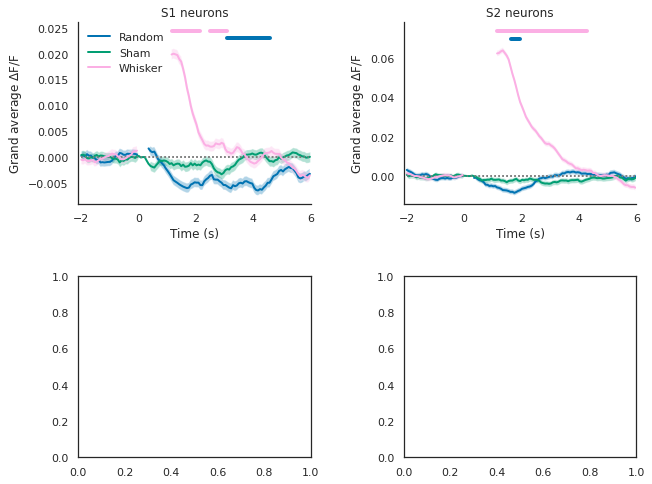

In [25]:
fig, ax_av = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})

dict_height_sign = {'sens_s1': 0.023, 'sens_s2': 0.07, 'proj_s1': 0.003, 'proj_s2': 0.007}
dict_addition_sign = {'sens_s1': 0.0015, 'sens_s2': 0.004, 'proj_s1': 0.0005, 'proj_s2': 0.001}
for i_xx, xx in enumerate(['sens']):
    for i_reg, reg in enumerate(['s1', 's2']):
        signficance_sham_only_dict = {k: v for k, v in p_val_super_dict[f'{xx}_{reg}'].items() if k[:4] == 'sham' and 'sensory' not in k}
        curr_ax = ax_av[i_xx, i_reg]
        dav.plot_grand_average(ds=selected_data_dict[f'{xx}_{reg}'], ax=curr_ax, smooth_mean=True,
                               tt_list=['random', 'sham', 'whisker'], 
                               plot_legend=(reg == 's1'),
                               plot_significance=True, test_method='cluster',
                               legend_profile=2 if xx == 'sens' else 0,
                                p_val_dict=signficance_sham_only_dict,
                                bottom_sign_bar=dict_height_sign[f'{xx}_{reg}'],
                                addition_sign_bar=dict_addition_sign[f'{xx}_{reg}'],
                               first_frame_significance=np.where(AllSesDict[xx].full_ds.artefact_bool)[0][-1] + 1)
        curr_ax.set_title(f'{reg.upper()} neurons')
        curr_ax.set_xlim([-2.1, 6])

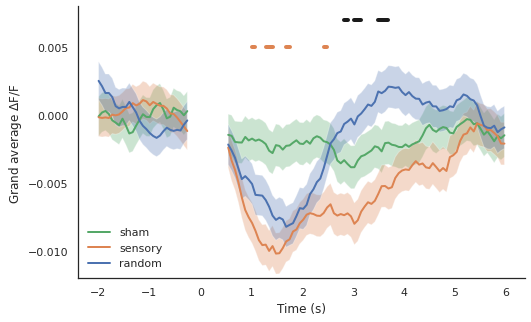

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx = 'sens'
reg = 's2'
dav.plot_grand_average(ds=selected_data_dict[f'{xx}_{reg}'], ax=ax, smooth_mean=True,
                       tt_list=tt_list_dict[xx], plot_legend=True,
                       plot_significance=True, test_method='holm_bonferroni', 
                       p_val_dict=p_val_super_dict[f'{xx}_{reg}'])

In [35]:
bonf_dict = dav.bonferroni_correction(p_val_dict=p_val_super_dict[f'{xx}_{reg}'])
holm_bonf_dict = dav.holm_bonferroni_correction(p_val_dict=p_val_super_dict[f'{xx}_{reg}'])
cluster_size_dict = dav.suprathreshold_cluster_size_test(p_val_dict=p_val_super_dict[f'{xx}_{reg}'])
time_array = selected_data_dict[f'{xx}_{reg}'].time.where(selected_data_dict[f'{xx}_{reg}'].frame_array >= 37, drop=True).data


sizes greater than th:  9.0 [ 1 12  6  3  2  1  4  2  1  2  1  1  2  2  1  1] [False  True False False False False False False False False False False
 False False False False]
sizes greater than th:  6.0 [1 1 1 3 1 6 3 1 1 2 1 3 2 1 1 1] [False False False False False  True False False False False False False
 False False False False]
sizes greater than th:  8.0 [ 2  2  1  1  1  2 21  1  2  1  2  1  2  1] [False False False False False False  True False False False False False
 False False]


## Grand averages from individual sessions:

In [6]:
assert len(selected_data_dict['sens_s1']) == 6
assert len(p_val_super_dict['sens_s1']) == 6

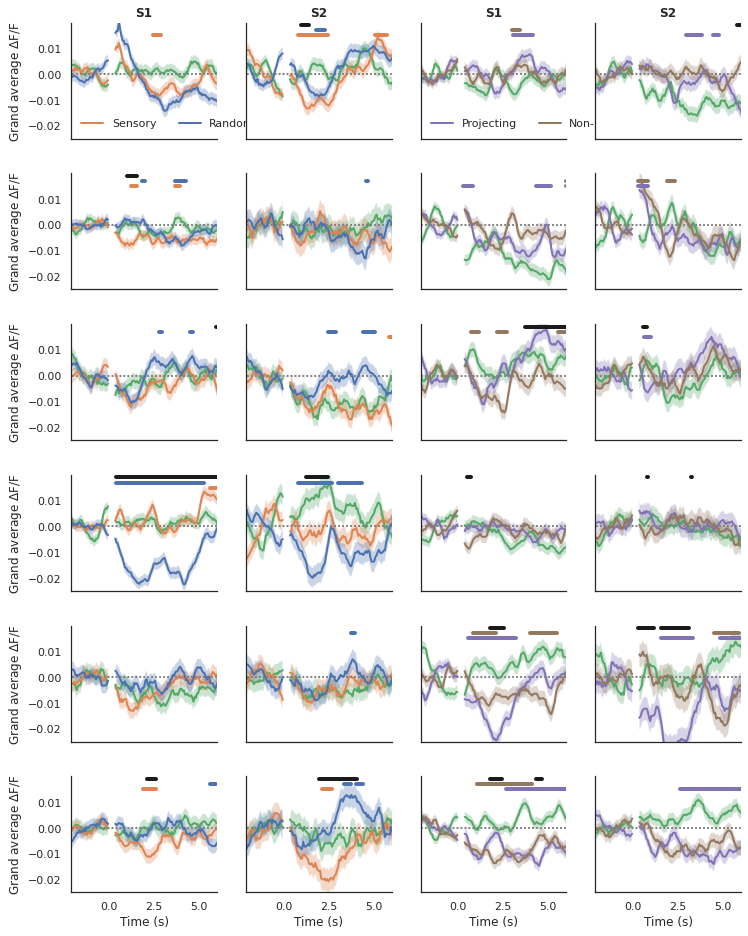

In [7]:
save_fig = True

fig, ax = plt.subplots(6, 4, figsize=(12, 16), gridspec_kw={'wspace': 0.2, 'hspace': 0.3})

n_ses = 6
i_row, i_col = 0, 0
for xx in ['sens', 'proj']:
    for reg in ['s1', 's2']:
        i_row = 0
        for i_s in range(n_ses):
            curr_ax = ax[i_row, i_col]
            # curr_ax.plot([-2, 6], [0, 0], linestyle=':', c='grey')
            dav.plot_grand_average(ds=selected_data_dict[f'{xx}_{reg}'][i_s], 
                                    ax=curr_ax, smooth_mean=True,
                                    tt_list=tt_list_dict[xx], plot_legend=np.logical_and(i_s == 0, reg == 's1'),
                                    plot_significance=True, test_method='cluster', 
                                    p_val_dict=p_val_super_dict[f'{xx}_{reg}'][i_s],
                                    bottom_sign_bar=0.015, addition_sign_bar=0.002,
                                    first_frame_significance=np.where(AllSesDict[xx].sess_dict[i_s].full_ds.artefact_bool)[0][-1] + 1,
                                    legend_profile=1)
            curr_ax.set_xlim([-2.1, 6])
            curr_ax.set_ylim([-0.025, 0.02])
            if i_col == 0:
                curr_ax.set_yticks([-0.02, -0.01, 0, 0.01])
            else:
                curr_ax.set_ylabel('')
                curr_ax.set_yticks([])
            if i_row == 0:
                curr_ax.set_title(f'{reg.upper()}', fontdict={'weight': 'bold'})
            if i_row != (n_ses - 1):
                curr_ax.set_xlabel('')
                curr_ax.set_xticks([])
            
            i_row += 1

        i_col += 1

if save_fig:
    plt.savefig('figs/supp_grand_av_per_indiv_session.pdf', bbox_inches='tight')

ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad
ad


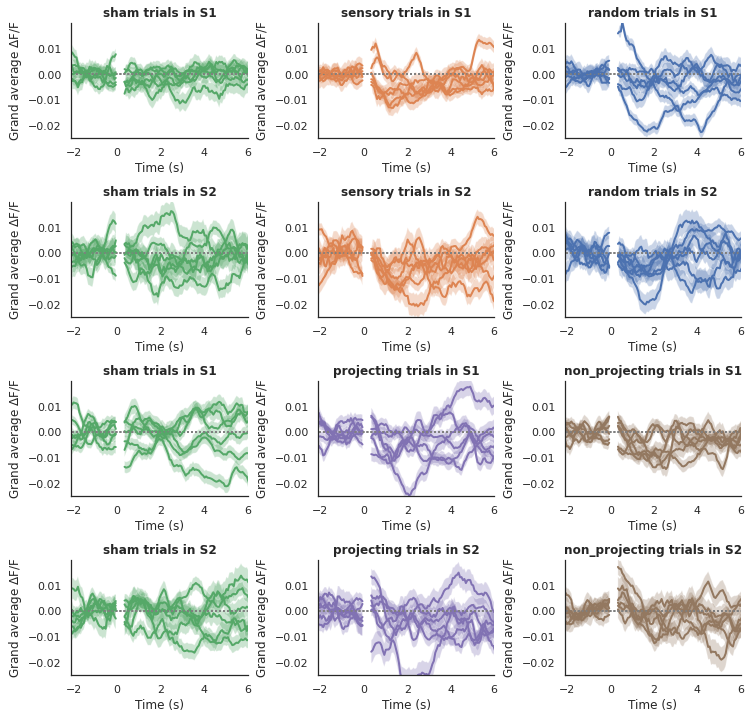

In [15]:
save_fig = True

fig, ax = plt.subplots(4, 3, figsize=(12, 12), gridspec_kw={'wspace': 0.4, 'hspace': 0.55})

n_ses = 6
i_row = 0
for i_xx, xx in enumerate(['sens', 'proj']):
    for i_reg, reg in enumerate(['s1', 's2']):
        ax_list = list(ax[i_row])
        assert len(ax_list) == 3
        for i_s in range(n_ses):
            dav.plot_grand_average(ds=selected_data_dict[f'{xx}_{reg}'][i_s], 
                                    ax=ax_list, smooth_mean=True,
                                    tt_list=tt_list_dict[xx], plot_legend=False,
                                    plot_significance=False)
                        
        for i_tt, tt in enumerate(tt_list_dict[xx]):
            curr_ax = ax_list[i_tt]
            curr_ax.set_xlim([-2.1, 6])
            curr_ax.set_ylim([-0.025, 0.02])
            curr_ax.set_yticks([-0.02, -0.01, 0, 0.01])
            curr_ax.set_title(f'{tt} trials in {reg.upper()}', fontdict={'weight': 'bold'})
        i_row += 1

if save_fig:
    plt.savefig('figs/supp_grand_av_all_indiv_sessions.pdf', bbox_inches='tight')